In [407]:
#Funcion para leer los archivos .dat 
def leer_archivo_dat(nombre_archivo):
    with open(nombre_archivo, "r", encoding="utf-8") as file:
        data = {}
        lista_aristas = []
        
        for linea in file:
            linea = linea.strip()

            if linea.startswith("NOMBRE"):
                data["nombre"] = linea.split(":")[1].strip()
            elif linea.startswith("COMENTARIO"):
                data["comentario"] = linea.split(":")[1].strip()
            elif linea.startswith("VERTICES"):
                data["vertices"] = int(linea.split(":")[1].strip())
            elif linea.startswith("ARISTAS_REQ"):
                data["aristas_requeridas"] = int(linea.split(":")[1].strip())
            elif linea.startswith("ARISTAS_NOREQ"):
                data["aristas_no_requeridas"] = int(linea.split(":")[1].strip())
            elif linea.startswith("VEHICULOS"):
                data["vehiculos"] = int(linea.split(":")[1].strip())
            elif linea.startswith("CAPACIDAD"):
                data["capacidad"] = int(linea.split(":")[1].strip())
            elif linea.startswith("TIPO_COSTES_ARISTAS"):
                data["tipo_costes"] = linea.split(":")[1].strip()
            elif linea.startswith("COSTE_TOTAL_REQ"):
                data["coste_total_requerido"] = int(linea.split(":")[1].strip())
            elif linea.startswith("LISTA_ARISTAS_REQ"):
                data["aristas_requeridas"] = []
            elif linea.startswith("("):  
                partes = linea.split(")")
                nodos = tuple(map(int, partes[0].replace("(", "").split(",")))
                coste = int(partes[1].split("coste")[1].split("demanda")[0].strip())
                demanda = int(partes[1].split("demanda")[1].strip())
                lista_aristas.append({"nodos": nodos, "coste": coste, "demanda": demanda})
            elif linea.startswith("DEPOSITO"):
                data["deposito"] = int(linea.split(":")[1].strip())

        data["lista_aristas_requeridas"] = lista_aristas

    return data

# Leer el archivo
archivo = "gdb23.dat"  # Ruta del archivo 
datos = leer_archivo_dat(archivo)

# Mostrar la información cargada
import pprint
pprint.pprint(datos)


{'aristas_no_requeridas': 0,
 'aristas_requeridas': [],
 'capacidad': 27,
 'comentario': '10000 (cota superior)',
 'coste_total_requerido': 223,
 'deposito': 1,
 'lista_aristas_requeridas': [{'coste': 1, 'demanda': 7, 'nodos': (1, 2)},
                              {'coste': 7, 'demanda': 1, 'nodos': (1, 3)},
                              {'coste': 1, 'demanda': 4, 'nodos': (1, 4)},
                              {'coste': 3, 'demanda': 9, 'nodos': (1, 5)},
                              {'coste': 3, 'demanda': 7, 'nodos': (1, 6)},
                              {'coste': 2, 'demanda': 8, 'nodos': (1, 7)},
                              {'coste': 1, 'demanda': 4, 'nodos': (1, 8)},
                              {'coste': 2, 'demanda': 1, 'nodos': (1, 9)},
                              {'coste': 2, 'demanda': 5, 'nodos': (1, 10)},
                              {'coste': 1, 'demanda': 8, 'nodos': (1, 11)},
                              {'coste': 5, 'demanda': 7, 'nodos': (2, 3)},
            

In [408]:
#Importar las librerias que se necesitan 
import networkx as nx
import time
import matplotlib.pyplot as plt
import numpy as np

In [409]:
def dijkstra_mas_corto(grafo, inicio, destino):
    #Encuentra el camino más corto en un grafo ponderado utilizando el algoritmo de Dijkstra.
    #Parámetros:
    #grafo (networkx.Graph): El grafo en el que se buscará el camino.
    #inicio (nodo): Nodo de inicio del camino.
    #destino (nodo): Nodo de destino del camino.
    #Retorna:
    #list: Una lista con la secuencia de nodos que conforman el camino más corto.
    return nx.shortest_path(grafo, source=inicio, target=destino, weight='costo')

In [410]:
#Esta funcion encuentra el arco mas cercano al nodo actual basado en el menor costo
def encontrar_arco_mas_cercano(grafo, nodo_actual, arcos_pendientes):
    min_costo = float('inf') # Inicializa la distancia mínima con un valor muy alto.
    arcos_candidatos = [] # Lista para almacenar los arcos con la menor distancia encontrada.

    #Encontrar el menor costo posible para ir desde nodo_actual a los extremos de los arcos pendientes.
    for u, v, data in arcos_pendientes:
        costo = nx.shortest_path_length(grafo, source=nodo_actual, target=u, weight='costo')
        if costo < min_costo:
            min_costo = costo

    # Guardar solo los arcos que tienen la menor distancia encontrada
    for u, v, data in arcos_pendientes:
        costo = nx.shortest_path_length(grafo, source=nodo_actual, target=u, weight='costo')
        if costo == min_costo:
            arcos_candidatos.append((u, v, data))

    # Buscar si hay un arco donde el nodo inicial sea el nodo_actual
    for i, (u, v, data) in enumerate(arcos_pendientes):
        if (u, v, data) in arcos_candidatos and u == nodo_actual:
            return i, (u, v, data)  # Prioriza el arco con nodo_actual como inicio

    # Si no hay un arco con nodo_actual como inicio, se elige cualquiera de los mejores candidatos
    for i, (u, v, data) in enumerate(arcos_pendientes):
        if (u, v, data) in arcos_candidatos:
            return i, (u, v, data)  # Devuelve el primero encontrado

In [411]:
def construir_rutas(grafo, capacidad, deposito):
    inicio_tiempo = time.time()  # Se registra el tiempo de inicio para medir la ejecución
    # Ordena los arcos por costo en orden ascendente para priorizar los más baratos
    arcos_pendientes = sorted([(u, v, data) for u, v, data in grafo.edges(data=True)], key=lambda x: x[2]['costo'])
    rutas = [] # Lista para almacenar las rutas construidas
    costos=[] # Lista para almacenar los costos de cada ruta
    # Mientras haya arcos pendientes de visitar
    while arcos_pendientes:
        ruta, carga_actual, costo_total = [(deposito, deposito, False)], 0,0
        nodo_actual = deposito
        while arcos_pendientes:
             # Encuentra el arco más cercano al nodo actual
            arco_seleccionado = encontrar_arco_mas_cercano(grafo, nodo_actual, arcos_pendientes)
            if not arco_seleccionado:
                break # Si no hay más arcos disponibles, termina la ruta
            _, (u, v, data) = arco_seleccionado

            # Verifica si la demanda del arco seleccionado supera la capacidad del vehículo
            if carga_actual + data["demanda"] > capacidad:
                # # Se inicializa como None para buscar otro arco con menor demanda
                arco_seleccionado = None

                # Busca un arco con menor demanda que pueda ser atendido dentro de la capacidad disponible
                for i, (a, b, d) in enumerate(arcos_pendientes):
                    if carga_actual + d["demanda"] <= capacidad:
                        arco_seleccionado = (i, (a, b, d))
                        break # Se selecciona el primer arco que cumpla la condición
                
                if not arco_seleccionado:
                    break # Si no hay un arco viable, se finaliza la ruta actual
                
                _, (u, v, data) = arco_seleccionado # Se actualiza con el arco encontrado

            # Encuentra el camino más corto desde la posición actual hasta el inicio del arco seleccionado
            camino_hacia_arco = dijkstra_mas_corto(grafo, nodo_actual, u)

            # Agrega los arcos del camino más corto a la ruta
            for j in range(len(camino_hacia_arco) - 1):
                ruta.append((camino_hacia_arco[j], camino_hacia_arco[j+1], False))
                costo_total += grafo[camino_hacia_arco[j]][camino_hacia_arco[j+1]]['costo']

            # Agregar el arco seleccionado a la ruta
            ruta.append((u, v, True))
            costo_total += data['costo']
            carga_actual += data["demanda"]
            nodo_actual = v # Se actualiza la posición del vehículo

            # Eliminar ambos sentidos del arco (u, v) y (v, u)
            arcos_pendientes = [(a, b, d) for a, b, d in arcos_pendientes if not ((a == u and b == v) or (a == v and b == u))]
        
        # Si la ruta no termina en el depósito, se encuentra el camino de retorno
        if nodo_actual != deposito:
            camino_de_retorno = dijkstra_mas_corto(grafo, nodo_actual, deposito)

            # Agrega los arcos del camino de retorno a la ruta
            for j in range(len(camino_de_retorno) - 1):
                ruta.append((camino_de_retorno[j], camino_de_retorno[j+1], False))
                costo_total += grafo[camino_de_retorno[j]][camino_de_retorno[j+1]]['costo']  
                
        rutas.append(ruta)
        costos.append(costo_total)
    tiempo_ejecucion = time.time() - inicio_tiempo
    return rutas,costos, tiempo_ejecucion

In [412]:
grafo = nx.DiGraph()

In [414]:
for arista in datos["lista_aristas_requeridas"]:
    nodo1, nodo2 = arista["nodos"]
    costo = arista["coste"]
    demanda = arista["demanda"]
    grafo.add_edge(nodo1, nodo2, costo=costo, demanda=demanda)
    grafo.add_edge(nodo2,nodo1,costo=costo,demanda=demanda)

In [415]:
# Imprimir las aristas en el formato correcto
for u, v, attrs in grafo.edges(data=True):
    print(f'grafo.add_edge({u}, {v}, costo={attrs["costo"]}, demanda={attrs["demanda"]})')

grafo.add_edge(1, 2, costo=1, demanda=7)
grafo.add_edge(1, 3, costo=7, demanda=1)
grafo.add_edge(1, 4, costo=1, demanda=4)
grafo.add_edge(1, 5, costo=3, demanda=9)
grafo.add_edge(1, 6, costo=3, demanda=7)
grafo.add_edge(1, 7, costo=2, demanda=8)
grafo.add_edge(1, 8, costo=1, demanda=4)
grafo.add_edge(1, 9, costo=2, demanda=1)
grafo.add_edge(1, 10, costo=2, demanda=5)
grafo.add_edge(1, 11, costo=1, demanda=8)
grafo.add_edge(2, 1, costo=1, demanda=7)
grafo.add_edge(2, 3, costo=5, demanda=7)
grafo.add_edge(2, 4, costo=1, demanda=6)
grafo.add_edge(2, 5, costo=8, demanda=6)
grafo.add_edge(2, 6, costo=1, demanda=5)
grafo.add_edge(2, 7, costo=3, demanda=4)
grafo.add_edge(2, 8, costo=7, demanda=9)
grafo.add_edge(2, 9, costo=8, demanda=9)
grafo.add_edge(2, 10, costo=7, demanda=7)
grafo.add_edge(2, 11, costo=2, demanda=8)
grafo.add_edge(3, 1, costo=7, demanda=1)
grafo.add_edge(3, 2, costo=5, demanda=7)
grafo.add_edge(3, 4, costo=7, demanda=6)
grafo.add_edge(3, 5, costo=1, demanda=2)
grafo.add_ed

In [416]:
#Llamar la funcion 
deposito = datos["deposito"]
capacidad_vehiculo = datos["capacidad"]
rutas = construir_rutas(grafo, capacidad_vehiculo, deposito)
print("Rutas construidas:")
for ruta in rutas:
    print(ruta)

Rutas construidas:
[[(1, 1, False), (1, 2, True), (2, 4, True), (4, 1, True), (1, 8, True), (8, 7, True), (7, 3, True), (3, 7, False), (7, 1, False)], [(1, 1, False), (1, 11, True), (11, 2, True), (2, 6, True), (6, 4, True), (4, 5, True), (5, 3, True), (3, 7, False), (7, 1, False), (1, 9, True), (9, 7, False), (7, 3, False), (3, 11, True), (11, 1, False)], [(1, 1, False), (1, 7, True), (7, 9, True), (9, 3, True), (3, 7, False), (7, 2, False), (2, 7, True), (7, 1, False)], [(1, 1, False), (1, 10, True), (10, 3, True), (3, 6, True), (6, 1, True), (1, 4, False), (4, 10, True), (10, 1, False)], [(1, 1, False), (1, 5, True), (5, 8, True), (8, 6, True), (6, 11, True), (11, 1, False), (1, 7, False), (7, 11, True), (11, 3, False), (3, 5, False), (5, 7, True), (7, 1, False), (1, 4, False), (4, 9, True), (9, 1, False)], [(1, 1, False), (1, 3, True), (3, 2, True), (2, 8, True), (8, 9, True), (9, 1, False), (1, 2, False), (2, 6, False), (6, 10, True), (10, 1, False)], [(1, 1, False), (1, 4, False)

In [417]:
#Listas de tiempo de ejecucion, capacidad, numero de arcos y numero de nodos para realizar graficas y calcular coeficientes de correlación 
tiempo=[0.0107 ,0.03455 ,0.01804 ,0.0123 , 0.032438 , 0.032267 , 0.015639 , 0.16636 , 0.172327 , 0.015649 , 0.10979 , 0.01579976 , 0.027392 , 0.029145 , 0.015637 , 0.01636219 , 0.03243875,0.03790307 , 0,0.013781 ,0.0671123 ,0.09622 , 0.194931 ]
capacidad=[5,5,5,5,5,5,5,27,27,10,50,35,41,21,37,24,41,37,27,27,27,27,27]
numero_arcos=[22,26,22,19,26,22,22,46,51,25,45,23,28,21,21,28,28,36,11,22,33,44,55]
numero_nodos=[12,12,12,11,13,12,12,27,27,12,22,13,10,7,7,8,8,9,8,11,11,11,11]

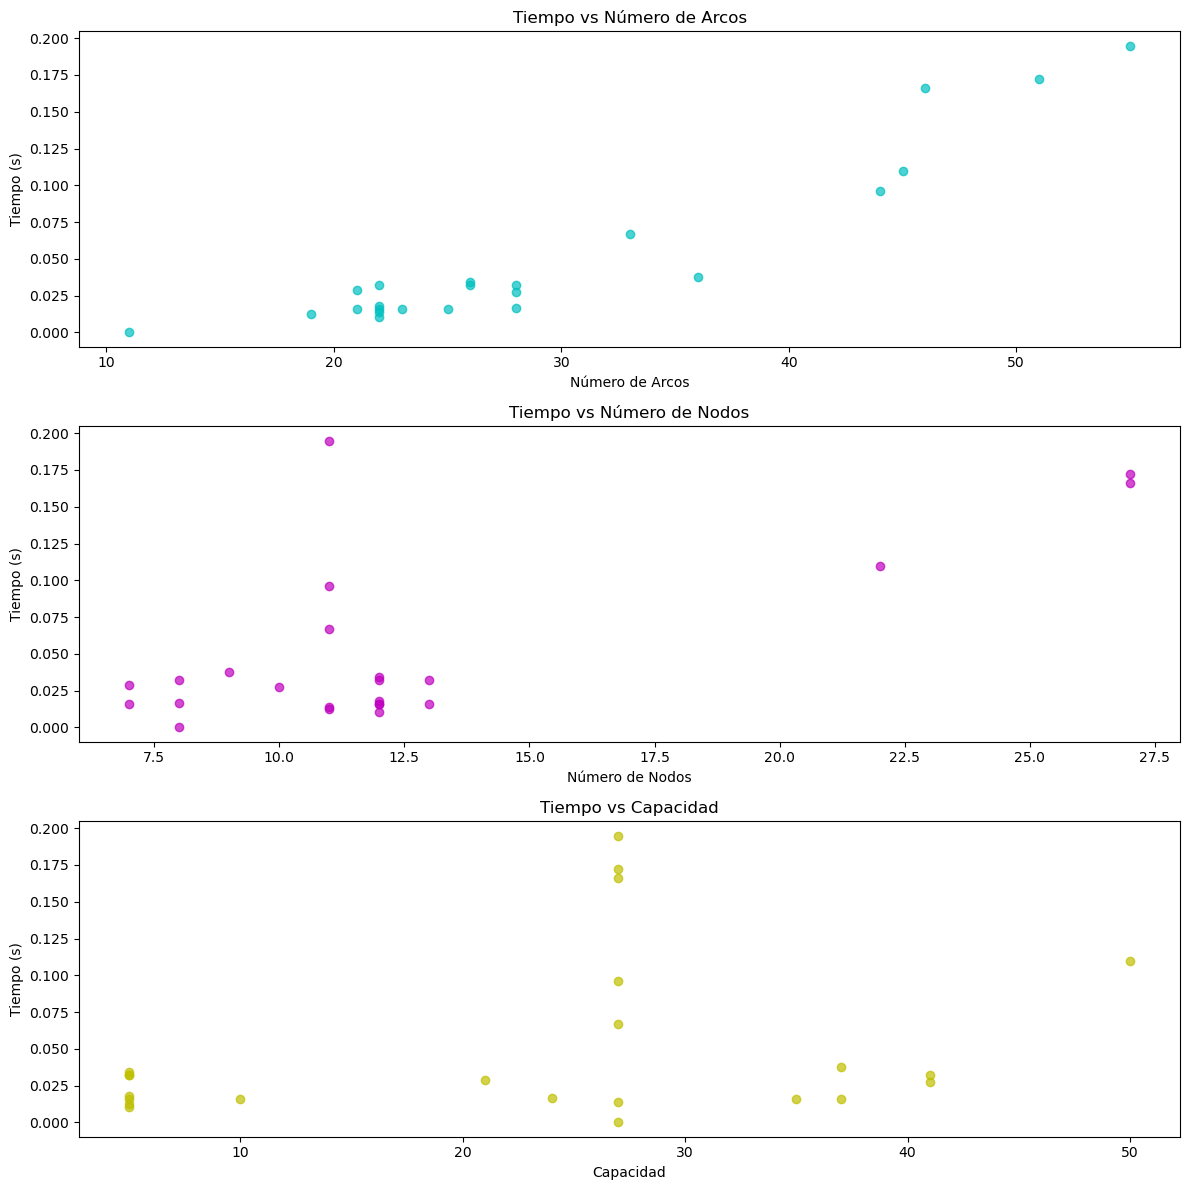

In [418]:
# Crear subgráficos
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

axs[0].scatter(numero_arcos, tiempo, color='c', alpha=0.7)
axs[0].set_xlabel("Número de Arcos")
axs[0].set_ylabel("Tiempo (s)")
axs[0].set_title("Tiempo vs Número de Arcos")

axs[1].scatter(numero_nodos, tiempo, color='m', alpha=0.7)
axs[1].set_xlabel("Número de Nodos")
axs[1].set_ylabel("Tiempo (s)")
axs[1].set_title("Tiempo vs Número de Nodos")

axs[2].scatter(capacidad, tiempo, color='y', alpha=0.7)
axs[2].set_xlabel("Capacidad")
axs[2].set_ylabel("Tiempo (s)")
axs[2].set_title("Tiempo vs Capacidad")

# Ajustar diseño
plt.tight_layout()
plt.show()


In [419]:
# Calcular coeficientes de correlación
correlaciones = {
    "Tiempo vs Número de Arcos": np.corrcoef(tiempo, numero_arcos)[0, 1],
    "Tiempo vs Número de Nodos": np.corrcoef(tiempo, numero_nodos)[0, 1],
    "Tiempo vs Capacidad": np.corrcoef(tiempo, capacidad)[0, 1],
}

# Mostrar resultados
for k, v in correlaciones.items():
    print(f"{k}: {v:.3f}")


Tiempo vs Número de Arcos: 0.939
Tiempo vs Número de Nodos: 0.690
Tiempo vs Capacidad: 0.293
